# Pipeline

Detailed step by step execution of the pipeline or one line code to run the pipeline.
The pipeline performs the following steps:
1. Load the data
2. Preprocess the video and extract RGB pixels
3. Apply an rPPG method to estimate the rPPG signal and extract heart rate
4. Evaluate the performance of the rPPG method based on time domain analysis (rPPG) and frequency domain analysis (HR)

In [ ]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
from pyVHR.analysis.pipelineLandmarks import *
import plotly.express as px

import constants
import pandas as pd
import numpy as np
import pandas as pd

vhr.plot.VisualizeParams.renderer = 'vscode' 

# Run pipeline

In [13]:
## Args
dataset_name = 'mr_nirp' 
landmarks = ['glabella','soft_triangle']
methods = ['cupy_CHROM', 'cpu_LGI']
roi_approach = 'landmark'
sampling_method = 'random'
nb_sample_points = 2000
seconds = 20
winsize = 10      
stride = 10

## Load Dataset

In [4]:
# -- LOAD A DATASET]

pipeline = PipielineLandmarks()
dataset = pipeline.get_dataset(dataset_name)
videoFPS, sigFPS = constants.get_fps(dataset_name)
print(f"{dataset_name.upper()}: Video fps = {videoFPS}, Signal fps = {sigFPS}")

allvideo = dataset.videoFilenames
videos = constants.get_video_settings(dataset_name)
print("Indexes of videos with specific settings: ", videos)

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

MR_NIRP: Video fps = 30, Signal fps = 60
Indexes of videos with specific settings:  {'MOTION': [0, 2, 4, 6, 9, 11, 13], 'STILL': [1, 3, 5, 7, 8, 10, 12, 14], 'MALE': [0, 1, 4, 5, 6, 7, 8, 9, 10, 13, 14], 'FEMALE': [2, 3, 11, 12], 'BEARD': [0, 1, 4, 5, 8, 9, 10, 13, 14], 'DARK': [0, 1, 2, 3, 4, 5, 13, 14]}
0 D:/datasets_rppg/MR-NIRP_indoor\Subject1_motion_940\Subject1_motion_940\RGB_corrected\Subject1_motion_940.avi
1 D:/datasets_rppg/MR-NIRP_indoor\Subject1_still_940-015\Subject1_still_940\RGB_corrected\Subject1_still_940.avi
2 D:/datasets_rppg/MR-NIRP_indoor\Subject2_motion_940\Subject2_motion_940\RGB_corrected\Subject2_motion_940.avi
3 D:/datasets_rppg/MR-NIRP_indoor\Subject2_still_940-002\Subject2_still_940\RGB_corrected\Subject2_still_940.avi
4 D:/datasets_rppg/MR-NIRP_indoor\Subject3_motion_940\Subject3_motion_940\RGB_corrected\Subject3_motion_940.avi
5 D:/datasets_rppg/MR-NIRP_indoor\Subject3_still_940-012\Subject3_still_940\RGB_corrected\Subject3_still_940.avi
6 D:/datasets_rppg

videoFileName :  D:/datasets_rppg/MR-NIRP_indoor\Subject2_still_940-002\Subject2_still_940\RGB_corrected\Subject2_still_940.avi
Video frame rate:      30 30.0
Length of the video: 1:05 min, timesGT is 210 s
Signal frame rate is 60 for MR_NIRP and signal is  209.45 seconds worth


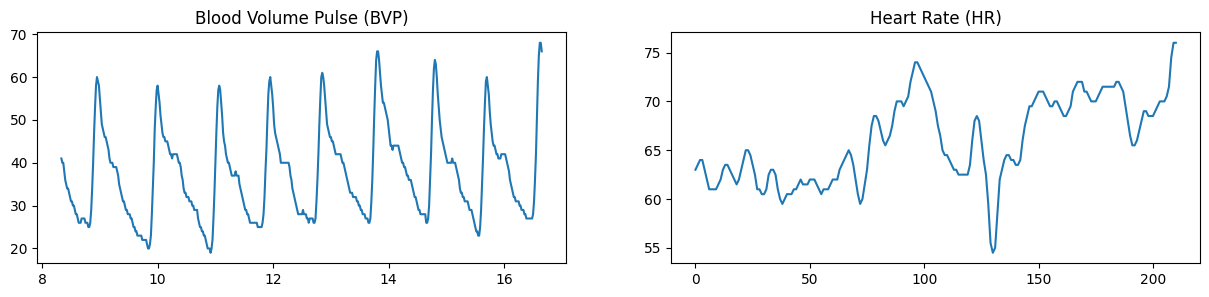

In [5]:
# -- PARAMETER SETTING

videoIdx = 3
fname = dataset.getSigFilename(videoIdx)
videoFileName = dataset.getVideoFilename(videoIdx)
fps = vhr.extraction.get_fps(videoFileName)
sigGT = dataset.readSigfile(fname)
bpmGT, timesGT = sigGT.getBPM(winsize) # STFT 42-240 BPM

print("videoFileName : ", videoFileName)
print('Video frame rate:     ',videoFPS, fps)
print(f"Length of the video: 1:05 min, timesGT is {len(timesGT)-1} s")
print(f"Signal frame rate is {sigFPS} for {dataset_name.upper()} and signal is ", sigGT.data.shape[1] / sigFPS, "seconds worth")

fig, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(np.arange(0, len(timesGT), 1/sigFPS)[500:1000], sigGT.data.T[500:1000])
ax[0].set_title('Blood Volume Pulse (BVP)')
ax[1].plot(timesGT, bpmGT)
ax[1].set_title('Heart Rate (HR)')
plt.show()

## Process Video

In [45]:
# Extract PPG signal
PPG_win, bpmGT, timesGT, subject_name = pipeline.get_signal_data(videoIdx, dataset)

# Extract RGB signal from video
windowed_sig, timesES = pipeline.extract_rgb(landmarks, videoFileName, roi_approach, sampling_method, nb_sample_points, seconds, winsize, stride, visualize=True, verb=False, cuda=True)

In [40]:
# -- INTERACTIVE VISUALIZATION OF PATCHES
visualize_patches_coll = pipeline.sig_processing.get_visualize_patches()
print('Number of frames processed: ',len(visualize_patches_coll))
# middle = int(len(visualize_patches_coll)/2)
# vhr.plot.interactive_image_plot(visualize_patches_coll[middle:middle+10],1.0)
vhr.plot.interactive_image_plot(visualize_patches_coll,1.0)

Number of frames processed:  0


## Process rPPG

In [49]:
bvps_win, timesES, bpmES = pipeline.extract_bpm( windowed_sig, timesES, videoFPS, roi_approach, method='cupy_CHROM', winsize=winsize, verb=False, cuda=True)

## Evaluate results

In [51]:
subject_name = constants.get_subject_name(dataset_name, videoFileName)
res = pipeline.evaluate_extraction(bvps_win, bpmES, bpmGT, timesES, timesGT, PPG_win, videoFPS, res=None, method='cupy_CHROM', videoFileName=subject_name, landmarks=landmarks, verb=False)
res.dataFrame

method dataset videoIdx       videoFilename                  landmarks  \
0  cupy_CHROM                   Subject2_still_940  (glabella, soft_triangle)   

       RMSE      MAE  PCC       CCC  SNR       MAX MAD  rPPG_PCC       DTW  \
0  0.868287  0.78125  1.0  0.538272  NaN  1.160156      0.461083  2.376656   

                                               bpmGT  \
0  [63.0, 63.5, 64.0, 64.0, 63.0, 61.999999999999...   

                        bpmES  \
0  [62.40234375, 64.16015625]   

                                              timeGT       timeES  
0  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...  [5.0, 15.0]

In [52]:
RMSE, MAE, MAX, PCC, CCC, SNR = res.dataFrame.iloc[0][['RMSE', 'MAE', 'MAX', 'PCC', 'CCC', 'SNR']]
printErrors(RMSE, MAE, MAX, PCC, CCC, SNR)
displayErrors(bpmES, bpmGT, timesES, timesGT)


    * Errors: RMSE = 0.87, MAE = 0.78, MAX = 1.16, PCC = 1.00, CCC = 0.54, SNR = nan


## Run the whole pipeline in one line

In [43]:
res = pipeline.run_pipeline(dataset_name, videoIdx, None, landmarks, roi_approach, sampling_method, nb_sample_points, seconds, winsize, stride, methods, visualize=False, verb=True, cuda=True)

Video:  D:/datasets_rppg/MR-NIRP_indoor\Subject2_still_940-002\Subject2_still_940\RGB_corrected\Subject2_still_940.avi
Video:  D:/datasets_rppg/MR-NIRP_indoor\Subject2_still_940-002\Subject2_still_940\RGB_corrected\Subject2_still_940.avi
Landmarks list : ['glabella', 'soft_triangle']

Processing Video D:/datasets_rppg/MR-NIRP_indoor\Subject2_still_940-002\Subject2_still_940\RGB_corrected\Subject2_still_940.avi

Roi processing...
 - Number of windows: 11
 - Win size: (#ROI, #landmarks, #frames) =  (2, 3, 300)
 - Extraction approach: landmark with 11 windows
cupy_CHROM

Pre filtering...
 - Pre-filter applied: BPfilter

BVP extraction...
 - Extraction method: cupy_CHROM
 - Post-filter applied: BPfilter

BPM estimation...
 - roi appproach: landmark

...done!


    * Errors: RMSE = 0.52, MAE = 0.42, MAX = 1.16, PCC = 0.95, CCC = 0.91, SNR = nan DTW = 1.59 rPPG_PCC = 0.45
cpu_LGI

Pre filtering...
 - Pre-filter applied: BPfilter

BVP extraction...
 - Extraction method: cpu_LGI
 - Post-filter